# Tools - Module Standoff for IEC TS 63126

### Calculation of module standoff distance according to IEC TS 63126

**Requirements:**
- Local weather data file or site longitude and latittude

**Objectives:**
1. Import weather data.
2. Calculate installation standoff - Level 1 and Level 2.
3. Calculate $X_{eff}$ from provided module temperature data.
4. Calculate $T_{98}$ for a given azimuth, tilt, and $X_{eff}$.
5. Plot $X_{min}$ for all azimuth and tilt for a given $T_{98}$.
6. Plot $X_{min}$ for Level 1, Level 2, or a $T_{98}$ for a given region.

**Background:**

This notebook calculates the a minimum effective standoff distance ($X_{eff}$) necessary for roof-mounted PV modules to ensure that the $98^{th}$ percentile operating temperature, $T_{98}$, remains under 70°C for compliance to IEC 61730 and IEC 61215. For higher $T_{98}$ values above 70°C or 80°C testing must be done to the specifications for Level 1 and Level 2 of IEC TS 63126. This method is outlined in the appendix of IEC TS 63126 and is based on the model from *[King 2004] and data from **[Fuentes, 1987] to model the approximate exponential decay in temperature, $T(X)$, with increasing standoff distance, $X$, as,

$$ X = -X_0 \ln\left(1-\frac{T_0-T}{\Delta T}\right), Equation 1 $$

where $T_0$ is the temperature for $X=0$ (insulated-back) and $\Delta T$ is the temperature difference between an insulated-back ($X=0$) and open-rack mounting configuration ($X=\infty)$.

 We used pvlib and data from the National Solar Radiation Database (NSRDB) to calculate the module temperatures for the insulated-back and open-rack mounting configurations and apply our model to obtain the minimum standoff distance for roof-mounted PV systems to achieve a temperature lower than a specified $T_{98}$. The following figure showcases this calulation for the entire world for an $X_{eff}$ that results in $T_{98}$=70°C. Values of $X_{eff}$ higher than this will require Level 1 or Level 2 certification. 

$*$ D. L. King, W. E. Boyson, and J. A. Kratochvil, "Photovoltaic array performance model," SAND2004-3535, Sandia National Laboratories, Albuquerque, NM, 2004. '\
$**$ M. K. Fuentes, "A simplified thermal model for Flat-Plate photovoltaic arrays," United States, 1987-05-01 1987. https://www.osti.gov/biblio/6802914


![alt text](T98_70C_standoff_Map.png)

In [1]:
# if running on google colab, uncomment the next line and execute this cell to install the dependencies
# and prevent "ModuleNotFoundError" in later cells:
#!pip install pvdeg==0.4.2

In [2]:
import os
import pvdeg
import pandas as pd
from pvdeg import DATA_DIR
import dask
import matplotlib.pyplot as plt
import seaborn as sns
import math
import numpy as np

In [3]:
# This information helps with debugging and getting support :)
import sys
import platform

print("Working on a ", platform.system(), platform.release())
print("Python version ", sys.version)
print("Pandas version ", pd.__version__)
print("pvdeg version ", pvdeg.__version__)
print("dask version", dask.__version__)
print(DATA_DIR)

Working on a  Windows 11
Python version  3.12.9 | packaged by Anaconda, Inc. | (main, Feb  6 2025, 18:49:16) [MSC v.1929 64 bit (AMD64)]
Pandas version  2.2.3
pvdeg version  0.5.1.dev457+g28fa10d38.d20250817
dask version 2025.5.1
C:\Users\rdaxini\Documents\GitHub\PVDegradationTools_NREL\pvdeg\data


## 1. Import Weather Data

The function has these minimum requirements when using a weather data file:
- Weather data containing (at least) DNI, DHI, GHI, Temperature, RH, and Wind-Speed data at module level.
- Site meta-data containing (at least) latitude, longitude, and time zone

Alternatively one may can get meterological data from the NSRDB or PVGIS with just the longitude and latitude. This function for the NSRDB (via NSRDB 'PSM3') works primarily for most of North America and South America. PVGIS works for most of the rest of the world (via SARAH 'PVGIS'). See the tutorial "Weather Database Access.ipynb" tutorial on PVdeg or Jensen et al. https://doi.org/10.1016/j.solener.2023.112092 for satellite coverage information.


In [4]:
# Get data from a supplied data file (Do not use the next box of code if using your own file)
weather_file = os.path.join(DATA_DIR, "psm3_demo.csv")
WEATHER_df, META = pvdeg.weather.read(weather_file, "csv")
print(META)

{'Source': 'NSRDB', 'Location ID': 145809.0, 'City': 'West Pleasant View', 'State': 'Colorado', 'Country': 'United States', 'Clearsky DHI Units': 'w/m2', 'Clearsky DNI Units': 'w/m2', 'Clearsky GHI Units': 'w/m2', 'Dew Point Units': 'c', 'DHI Units': 'w/m2', 'DNI Units': 'w/m2', 'GHI Units': 'w/m2', 'Solar Zenith Angle Units': 'Degree', 'Temperature Units': 'c', 'Pressure Units': 'mbar', 'Relative Humidity Units': '%', 'Precipitable Water Units': 'cm', 'Wind Direction Units': 'Degrees', 'Wind Speed Units': 'm/s', 'Cloud Type -15': 'N/A', 'Cloud Type 0': 'Clear', 'Cloud Type 1': 'Probably Clear', 'Cloud Type 2': 'Fog', 'Cloud Type 3': 'Water', 'Cloud Type 4': 'Super-Cooled Water', 'Cloud Type 5': 'Mixed', 'Cloud Type 6': 'Opaque Ice', 'Cloud Type 7': 'Cirrus', 'Cloud Type 8': 'Overlapping', 'Cloud Type 9': 'Overshooting', 'Cloud Type 10': 'Unknown', 'Cloud Type 11': 'Dust', 'Cloud Type 12': 'Smoke', 'Fill Flag 0': 'N/A', 'Fill Flag 1': 'Missing Image', 'Fill Flag 2': 'Low Irradiance', '

In [5]:
# This routine will get a meteorological dataset from anywhere in the world where it is available
#weather_id = (24.7136, 46.6753) #Riyadh, Saudi Arabia
#weather_id = (35.6754, 139.65) #Tokyo, Japan
#weather_id = (-43.52646, 172.62165) #Christchurch, New Zealand
#weather_id = (64.84031, -147.73836) #Fairbanks, Alaska
#weather_id = (65.14037, -21.91633) #Reykjavik, Iceland
#weather_id = (33.4152, -111.8315) #Mesa, Arizona
#WEATHER_df, META = pvdeg.weather.get_anywhere(id=weather_id)
#print(META)

## 2. Calculate Installation Standoff Minimum - Level 1 and Level 2

According to IEC TS 63126, Level 0, Level 1 and Level 2 certification is limited to T₉₈<70°C, <80°C and <90°C, respectively. Level 0 certification is essentially compliance to IEC 61730 and IEC 61215. The default value of T₉₈<70°C represents the minimium gap to avoid higher temperature certification according to IEC TS 63126. This minimum standoff ($x_{min}$) is the distance between the bottom of the module frame and the roof and can be extimated for a given environment as, 

$$ X_{min} = -X_0 \ln\left(1-\frac{T_{98,0}-T}{ T_{98,0}- T_{98,inf}}\right), Equation 2 $$

where $T_{98,0}$ is the $98^{th}$ percentile temperature for an insulated back module and $T_{98,inf}$ is the $98^{th}$ percentile temperature for an open rack mounted module.

Once the meterological data has been obtained, the input parameter possibilities are:

- T₉₈ : Does not necessarily need to be set at 70°C or 80°C for IEC TS 63216, you might want to use a different number to compensate for a thermal aspect of the particular system you are considering. The default is 70°C.
- tilt : tilt from horizontal of PV module. The default is 0°.
- azimuth : azimuth in degrees from North. The default is 180° for south facing.
- sky_model : pvlib compatible model for generating sky characteristics (Options: 'isotropic', 'klucher', 'haydavies', 'reindl', 'king', 'perez'). The default is 'isotropic'.
- temp_model : pvlib compatible module temperature model. (Options: 'sapm', 'pvsyst', 'faiman', 'sandia'). The default is 'sapm'.
- conf_0 : Temperature model for hotest mounting configuration. Default is "insulated_back_glass_polymer".
- conf_inf : Temperature model for open rack mounting. Default is "open_rack_glass_polymer".
- x_0 : thermal decay constant [cm] (see documentation). The default is 6.5 cm.
- wind_factor : Wind speed power law correction factor to account for different wind speed measurement heights between weather database (e.g. NSRDB) and the tempeature model (e.g. SAPM). The default is 0.33.

The following is the minimum function call. It defaults to horizontal tilt and T₉₈=70°C.

In [6]:
standoff = pvdeg.standards.standoff(weather_df=WEATHER_df, meta=META)
print(pvdeg.standards.interpret_standoff(standoff))

The array surface_tilt angle was not provided, therefore the latitude of  39.7 was used.
The array azimuth was not provided, therefore an azimuth of  180.0 was used.
The estimated T₉₈ of an insulated-back module is 77.0°C. 
The estimated T₉₈ of an open-rack module is 50.6°C. 
Level 0 certification is valid for a standoff greather than 2.0 cm. 
Level 1 certification is required for a standoff less than 2.0 cm. 
Level 2 certification is never required for this temperature                            profile.


The following is a full function call for both T₉₈=70°C and 80°C separately even though the second standoff distance can be calculated using only T98_0 and T98_inf. With this function, one may also want to change the tilt, azimuth, or T98. 

In [7]:
standoff_1 = pvdeg.standards.standoff(
    weather_df=WEATHER_df,
    meta=META,
    T98=70,
    tilt=META["latitude"],
    azimuth=None,
    sky_model="isotropic",
    temp_model="sapm",
    conf_0="insulated_back_glass_polymer",
    conf_inf="open_rack_glass_polymer",
    x_0=6.5,
    wind_factor=0.33,
)
print("First calculation standoff = ", "%.1f" % standoff_1["x"].iloc[0], " cm.")
standoff_2 = pvdeg.standards.standoff(
    weather_df=WEATHER_df,
    meta=META,
    T98=80,
    tilt=META["latitude"],
    azimuth=None,
    sky_model="isotropic",
    temp_model="sapm",
    conf_0="insulated_back_glass_polymer",
    conf_inf="open_rack_glass_polymer",
    x_0=6.5,
    wind_factor=0.33,
)
print("Second calculation standoff = ", "%.1f" % standoff_2["x"].iloc[0], " cm.")
print(pvdeg.standards.interpret_standoff(standoff_1=standoff_1, standoff_2=standoff_2))

The array azimuth was not provided, therefore an azimuth of  180.0 was used.
First calculation standoff =  2.0  cm.
The array azimuth was not provided, therefore an azimuth of  180.0 was used.
Second calculation standoff =  0.0  cm.
The estimated T₉₈ of an insulated-back module is 77.0°C. 
The estimated T₉₈ of an open-rack module is 50.6°C. 
Level 0 certification is valid for a standoff greather than 2.0 cm. 
Level 1 certification is required for a standoff less than 2.0 cm. 
Level 2 certification is never required for this temperature                            profile.


## 3. Calculate $X_{eff}$ from provided module temperature data.

To do this calculation, one must use a set of data with: 
   - meterological irradiance data sufficient to calculate the POA irradiance (DHI, GHI, and DNI),
   - ambient temperature data,
   - wind speed at module height, (wind_factor=0.33 will be used unless otherwise specified)
   - temperature measurements of the module in the test system. Ideally this would be measured under a worst case scenario that maximizes the module temperature for a given site,
   - geographic meta data including longitude and latitude,

To create a weather file of your own, copy the format of the example file 'xeff_demo.csv'. This is formatted with the first row containing meta data variable names, the second row containing the corresponding values, the third row containing meteorological data headers, and all the remaining rows containing the meteorological data.

To do this calculation, one should also filter the data to remove times when the sun is not shining or when snow is likely to be on the module. The recommendations and programmed defaults are to use poa_min=100 W/m² and data when the minimum ambient temperature t_amb_min=0.

In [8]:
# Read the weather file
weather_file = os.path.join(DATA_DIR, "xeff_demo.csv")
xeff_weather, xeff_meta = pvdeg.weather.read(weather_file, "csv")
# Pull measured temperature and calculate theoretical insulated back module temperature and open rack module temperature
T_0, T_inf, xeff_poa = pvdeg.standards.eff_gap_parameters(
    weather_df=xeff_weather,
    meta=xeff_meta,
    sky_model="isotropic",
    temp_model="sapm",
    conf_0="insulated_back_glass_polymer",
    conf_inf="open_rack_glass_polymer",
    wind_factor=0.33,
)
# Now calculate X_eff.
x_eff = pvdeg.standards.eff_gap(
    T_0,
    T_inf,
    xeff_weather["module_temperature"],
    xeff_weather["temp_air"],
    xeff_poa["poa_global"],
    x_0=6.5,
    poa_min=100,
    t_amb_min=0,
)
print("The effective standoff for this system is", "%.1f" % x_eff, "cm.")

The effective standoff for this system is 2.0 cm.


## 4. Calculate $T_{98}$ for a given azimuth, tilt, and $X_{eff}$.

Equation 2 can be reorganized as,

$$ T_{98} = T_{98,0}  -( T_{98,0}- T_{98,inf}) \left(1-e^{-\frac{x_{eff}}{x_{0}}}\right), Equation 3 $$

and used to calculate the $98^{th}$ percential temperature, $T_{98}$, for a PV system having a given effective standoff height, $X_{eff}$,  for an arbitrarily oriented module. Here, $T_{98,0}$ is the $98^{th}$ percentile for an insulated-back module and $T_{98,inf}$ is the $98^{th}$ percentile for a rack-mounted module. The input parameter possibilities are the same as shown in Objective #2 above, but the example below uses the default parameters. The actual tilt [degrees], azimuth [degrees] and $X_{eff}$ [cm] can be modifed as desired.

In [9]:
# This is the minimal function call using the common default settings to estimate T₉₈.
T_98 = pvdeg.standards.T98_estimate(
    weather_df=WEATHER_df,
    meta=META,
    tilt=-META['latitude'],
    azimuth=None,
    x_eff=10)
print ('The 98ᵗʰ percential temperature is estimated to be' , '%.1f' % T_98 , '°C.')

The array azimuth was not provided, therefore an azimuth of  180.0 was used.
The 98ᵗʰ percential temperature is estimated to be 45.7 °C.


In [10]:
# This code will calculate the temperature for an arbitrary x_eff distance. Either set of kwargs can be modified and use.
#irradiance_kwarg ={
#    "axis_tilt": None,
#    "axis_azimuth": None,
#    "x_eff": 10,
#    "module_mount": '1_axis'}
irradiance_kwarg ={
    "tilt": META['latitude'],
    "azimuth": None,
    "x_eff": 10,
    "module_mount": "fixed"}

T_xeff = pvdeg.standards.x_eff_temperature_estimate(
    weather_df=WEATHER_df,
    meta=META,
    **irradiance_kwarg)

print ('The 98ᵗʰ percential temperature is estimated to be' , '%.1f' % np.percentile(T_xeff, 98) , '°C.')

The array azimuth was not provided, therefore an azimuth of  180.0 was used.
The 98ᵗʰ percential temperature is estimated to be 56.0 °C.


## 5. Plot $X_{min}$ for all azimuth and tilt for a given $T_{98}$.

The temperature of a system is affected by the orientation. This section will scan all possible tilts and azimuths calculating the minimum standoff distance for a given $T_{98}$. Similar additional factors as above can also be modified but are not included here for simplicity. The tilt_step and azimuth_step are the number of degrees for each step for the 90° and 180° tilt and azimuth spans, respectively. The default for this calculation is for $T_{98}$=70°C, the boundary between Level 0 and Level 1 requirements. The temperature model information given below is unnecessary as these are default values that would get populated automatically. However, they were included here for clarity into a standard practice as per IEC TS 63126.

$$ X_{min} = -X_0 \ln\left(1-\frac{T_{98,0}-T}{ T_{98,0}- T_{98,inf}}\right), Equation 2 $$

In [11]:
# Scans through all the azimuth and tilt running the minimum standoff calculation
# Set up keyword parameters for the calculation

kwarg_x = dict(
    sky_model="isotropic",
    temp_model="sapm",
    conf_0="insulated_back_glass_polymer",
    conf_inf="open_rack_glass_polymer",
    T98=70,
    x_0=6.5,
    wind_factor=0.33,
)
# Run the calculation
x_azimuth_step = 10
x_tilt_step = 10
standoff_series = pvdeg.utilities.tilt_azimuth_scan(
    weather_df=WEATHER_df,
    meta=META,
    tilt_step=x_tilt_step,
    azimuth_step=x_azimuth_step,
    func=pvdeg.standards.standoff_x,
    **kwarg_x,
)

The next cell creates a plot of the calculated data. Some of the things you may want to change are:
- cmap="Spectral_r": Change to have different colors
- plt.title : This will change the plot title.
- figsize=(16,4) : Change the plot dimensions and/or aspect ratio.
- vmax=None : This can be set to a numeric value to control the depth scale maximum
- vmin=0 : This controls the minimum of the depth scale.
- v_ticks=37 : This changes the number of vertical tick marks
- h_ticks=10 : This changes the number of horizontal tick marks
- Unblock the last two lines to ouput the plot as an *.png image file

[WinError 183] Cannot create a file when that file already exists: 'c:\\Users\\rdaxini\\Documents\\GitHub\\PVDegradationTools_NREL\\TEMP\\results'


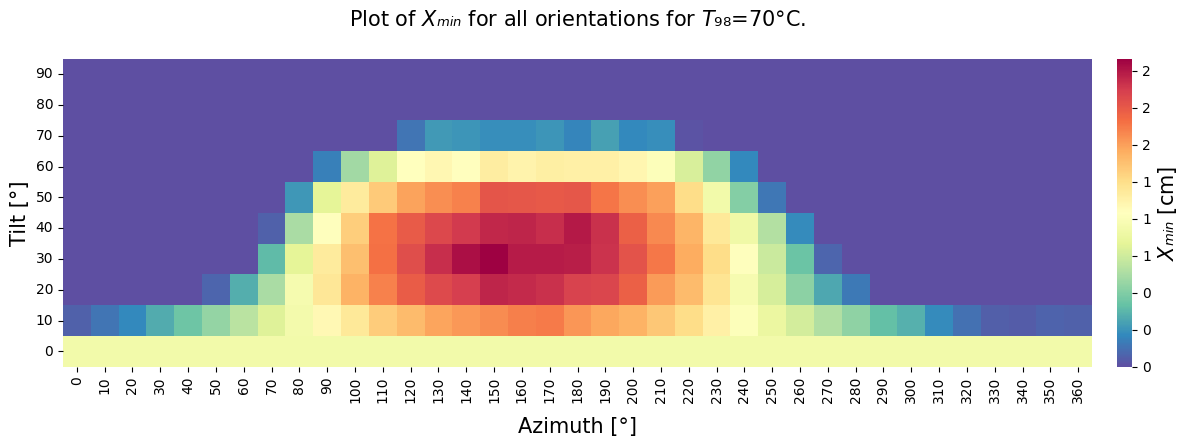

In [12]:
standoff_series_df = pd.DataFrame(
    {
        "Tilt": standoff_series[:, 0],
        "Azimuth": standoff_series[:, 1],
        "Xₘᵢₙ": standoff_series[:, 2],
    }
)
x_fig = plt.figure(figsize=(16, 4))
plt.title(
    r"Plot of $\it{Xₘᵢₙ}$ for all orientations for $\it{T₉₈}$="
    + "%.0f" % kwarg_x["T98"]
    + "°C.",
    fontsize=15,
    y=1.08,
)
x_fig = sns.heatmap(
    standoff_series_df.pivot(index="Tilt", columns="Azimuth", values="Xₘᵢₙ"),
    cbar_kws={"label": "Xₘᵢₙ", "format": "%.0f", "pad": 0.02},
    cmap="Spectral_r",
    vmin=0,
    vmax=None,
)

h_ticks = 37
x_number = math.ceil(360 / x_azimuth_step) + 1
x_ticks = [
    (x * (360 / (h_ticks - 1)) / x_azimuth_step + 0.5) for x in range(h_ticks - 1)
]
x_labels = [("%.0f" % (360 / (h_ticks - 1) * x)) for x in range(h_ticks)]
x_ticks.append(x_number - 0.5)
x_fig.set_xticks(x_ticks)
x_fig.set_xticklabels(x_labels, rotation=90)

v_ticks = 10
y_number = math.ceil(90 / x_tilt_step) + 1
y_ticks = [(x * (90 / (v_ticks - 1)) / x_tilt_step + 0.5) for x in range(v_ticks - 1)]
y_labels = [("%.0f" % (90 / (v_ticks - 1) * x)) for x in range(v_ticks)]
y_ticks.append(y_number - 0.5)
x_fig.set_yticks(y_ticks)
x_fig.set_yticklabels(y_labels, rotation=0)

x_fig.set_xlabel("Azimuth [°]", fontsize=15, labelpad=10)
x_fig.set_ylabel("Tilt [°]", fontsize=15)
x_fig.figure.axes[-1].set_ylabel(r"$\it{Xₘᵢₙ}$ [cm]", size=15)
x_fig.invert_yaxis()

output_folder = os.path.join(
    os.path.dirname(os.path.dirname(os.getcwd())), "TEMP", "results"
)
try:
    os.makedirs(output_folder)
except OSError as error:
    print(error)

plt.savefig(
    os.path.join(output_folder, "Standoff_Scan.png"), bbox_inches="tight"
)  # Creates an image file of the standoff plot
plt.show()

## 6. Plot $T_{98}$  for all azimuth and tilt for a given $X_{eff}$.

The temperature of a system is affected by the orientation and the effective standoff, $X_{eff}$, of the system. This section will scan all possible tilts and azimuths calculating the $T_{98}$ for a given $X_{eff}$. As above, additional factors can be modified but are not included here for simplicity. The tilt_step and azimuth_step are the number of degrees for each step for the 90° and 180° tilt and azimuth spans, respectively. The default for this calculation is for $X_{eff}$=10 cm, a common effective standoff distance on a rooftop system. A value of $X_{eff}$=None will run the calculations for an open rack system and $X_{eff}$=0 for an insulated-back system.

In [13]:
# Scans through all the azimuth and tilt running the 98ᵗʰ percentile temperature calculation.
# Set up keyword parameters for the calculation
kwarg_T = dict(
    sky_model="isotropic",
    temp_model="sapm",
    conf_0="insulated_back_glass_polymer",
    conf_inf="open_rack_glass_polymer",
    x_eff=5,
    x_0=6.5,
    wind_factor=0.33,
)
# Run the calculation
T_azimuth_step = 10
T_tilt_step = 10
T98_series = pvdeg.utilities.tilt_azimuth_scan(
    weather_df=WEATHER_df,
    meta=META,
    tilt_step=T_tilt_step,
    azimuth_step=T_azimuth_step,
    func=pvdeg.standards.T98_estimate,
    **kwarg_T,
)

The next cell creates a plot of the calculated data. Some of the things you may want to change are:
- cmap="Spectral_r": Change to have different colors
- plt.title : This will change the plot title.
- figsize=(16,4) : Change the plot dimensions and/or aspect ratio.
- vmax=None : This can be set to a numeric value to control the depth scale maximum
- vmin=None : This controls the minimum of the depth scale.
- v_ticks=37 : This changes the number of vertical tick marks
- h_ticks=10 : This changes the number of horizontal tick marks
- Unblock the last two lines to ouput the plot as an *.png image file

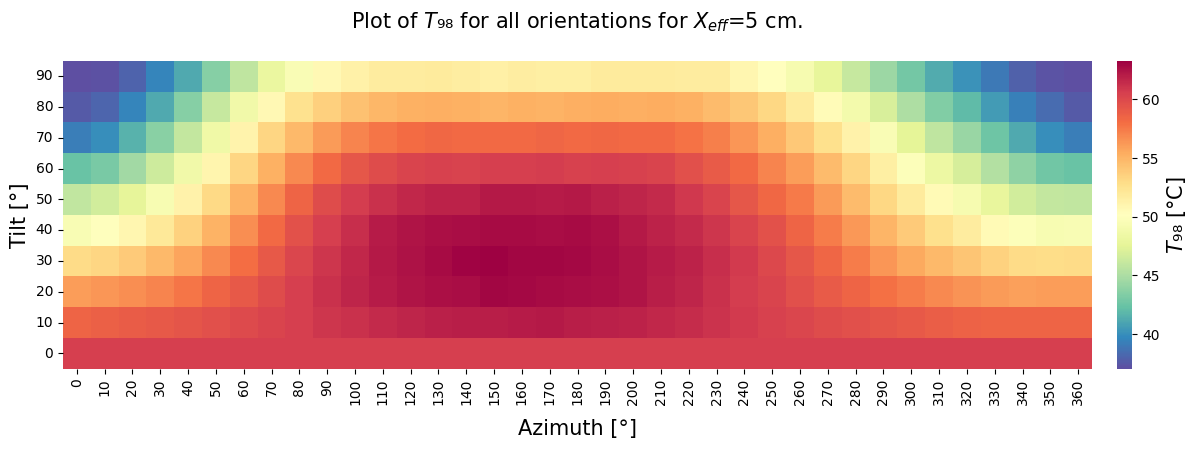

In [14]:
# This produces the plot of the data
T98_series_df = pd.DataFrame(
    {"Tilt": T98_series[:, 0], "Azimuth": T98_series[:, 1], "T₉₈": T98_series[:, 2]}
)
T98_fig = plt.figure(figsize=(16, 4))
if kwarg_T["x_eff"] == None:
    plt.title(
        r"Plot of $\it{T₉₈}$ for all orientations for an open-rack mounting.",
        fontsize=15,
        y=1.08,
    )
else:
    plt.title(
        r"Plot of $\it{T₉₈}$ for all orientations for $X_{eff}$="
        + "%.0f" % kwarg_T["x_eff"]
        + " cm.",
        fontsize=15,
        y=1.08,
    )
T98_fig = sns.heatmap(
    T98_series_df.pivot(index="Tilt", columns="Azimuth", values="T₉₈"),
    cbar_kws={"label": "Xₘᵢₙ", "format": "%.0f", "pad": 0.02},
    cmap="Spectral_r",
    vmin=None,
    vmax=None,
)

h_ticks = 37
x_number = math.ceil(360 / T_azimuth_step) + 1
x_ticks = [
    (x * (360 / (h_ticks - 1)) / T_azimuth_step + 0.5) for x in range(h_ticks - 1)
]
x_labels = [("%.0f" % (360 / (h_ticks - 1) * x)) for x in range(h_ticks)]
x_ticks.append(x_number - 0.5)
T98_fig.set_xticks(x_ticks)
T98_fig.set_xticklabels(x_labels, rotation=90)

v_ticks = 10
y_number = math.ceil(90 / T_tilt_step) + 1
y_ticks = [(x * (90 / (v_ticks - 1)) / T_tilt_step + 0.5) for x in range(v_ticks - 1)]
y_labels = [("%.0f" % (90 / (v_ticks - 1) * x)) for x in range(v_ticks)]
y_ticks.append(y_number - 0.5)
T98_fig.set_yticks(y_ticks)
T98_fig.set_yticklabels(y_labels, rotation=0)

T98_fig.set_xlabel("Azimuth [°]", fontsize=15, labelpad=10)
T98_fig.set_ylabel("Tilt [°]", fontsize=15)
T98_fig.figure.axes[-1].set_ylabel(r"$\it{T₉₈}$ [°C]", size=15)
T98_fig.invert_yaxis()

plt.savefig(
    os.path.join(output_folder, "T98_Scan.png"), bbox_inches="tight"
)  # Creates an image file of the standoff plot
plt.show(T98_fig)

## 7. Plot $X_{min}$ for a $T_{98}$, and plot $T_{98}$ for a given region.

This last Objective is much more complicated and is set up to utilize acess to a lot of computational power to run many sites simultaneously to create a regional map of standoff distance. 
For more in-depth instructions on doing this, look at the tutorial "Scenario - Geospatial.ipynb" here in PVDeg.

Step #1: Create an object, "geospatial_standoff_scenario" to be used to run the computations.

In [15]:
geospatial_standoff_scenario = pvdeg.GeospatialScenario(
    name="standoff geospatial",
    geospatial=True,
)

Step #2: Identifies a subset of locations from the database to run the computations.
Specifically all are from the NSRDB.

In [ ]:
geospatial_standoff_scenario.addLocation(
    state="Colorado", county="Summit"
)  # Identifies a subset of locations from the database to run the computations. Specifically all are from the NSRDB.

ConnectionError: 
            connected to  not a node of kestrel.hpc.nrel.gov")
            

Step #3: indicate which function will be run. Here the default is the standoff calculation, but it could be any other function with a key word argument dictionary.
Here the 98th percential temperature is defined as 70C, but any arbitrary value can be specified.

In [ ]:
geospatial_standoff_scenario.addJob(
    func=pvdeg.standards.standoff, func_params={"T98": 70}
)

Step #4: Run the scenario

In [ ]:
geospatial_standoff_scenario.run()

Step #5: Create a plot of the standoff calculation.

In [ ]:
geospatial_standoff_scenario.plot_world("x")

In [ ]:
geospatial_standoff_scenario.plot_world("T98_inf")

## 8. Save data outputs.

This cell contains a number of pre-scripted commands for exporting and saving data. The code to save plots is located after the plot creation and is blocked by default. First check that the output folder exists, then unblock the code for data you would like to save.

In [ ]:
print ("Your results will be stored in %s" % output_folder)
print ('The folder must already exist or the file will not be created')

pvdeg.weather.write(data_df=WEATHER_df, metadata=META, savefile=os.path.join(output_folder, 'WeatherFile.csv')) #Writes the meterological data to an *.csv file.

pd.DataFrame(standoff_series_df).to_csv(os.path.join(output_folder, 'Standoff_Scan.csv')) #Writes a file with the Tilt and Azimuth scan calculations of standoff.

pd.DataFrame(T98_series_df).to_csv(os.path.join(output_folder, 'T98_Scan.csv')) #Writes a file with the Tilt and Azimuth scan calculations of T98.
